<center>
    <h1>卷积神经网络--Fashion Mnist数据分析</h1>
 </center>

<center>
    <h2>1. 背景介绍</h2>
 </center>

<center>
    <h3>Fashion Mnist 数据集</h3>
 </center>

#### 数据收集自Zalando（一个时尚网站）的文章图片 

- 60,000 个training examples 
- 10,000 个testing examples
- 28×28 灰度图

#### Why Not Mnist?

- Mnist 常常作为第一个学习机器学习的数据集
- 但它太简单了："_If it doesn't work on MNIST, **it won't work at all**", they said. "Well, if it does work on MNIST, it may still fail on others._“
- Fashion Mnist 任务更加难些，与现代CV研究更加接近


<img src="../pictures/fashion_mnist_intro.png" alt="data_intro1" width="400"/>

<center>
    <h3>目标：图像分类</h3>
 </center>

 
 - **分类问题（10分类）**
 
 - 样本均衡：每个类别6000个样本
 
| 类别编号 | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
| :- | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 类别 | T-shirt/top | Trouser | Pullover | Dress | Coat | Sandal | Shirt | Sneaker | Bag | Ankle boot |

- 可以通过如下方式读入数据展示

In [3]:
from utils import mnist_reader
import matplotlib.pyplot as plt
import numpy as np

# 读入训练集和测试集数据
X_train0, y_train0 = mnist_reader.load_mnist('./', kind = "train")
X_test, y_test = mnist_reader.load_mnist('./', kind = "t10k")

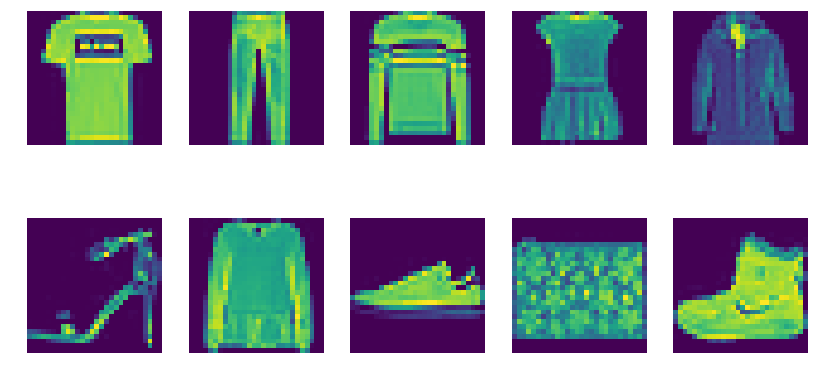

In [4]:
# 做出图形
plt.rcParams['figure.figsize'] = [14, 7]
# 每一类的第一个图
for i in range(10):
    ind = np.where(y_train0==i)[0][0]
    img1 = X_train0[ind,:]
    plt.subplot(2, 5, i+1)
    plt.imshow(img1.reshape((28, 28)))
    plt.axis('off')

<center>
    <h2>2. 逻辑回归</h2>
 </center>

<center>
    <h3>准备工作</h3>
 </center>

#### 准备工作 1：模块引入及框架设置

In [2]:
# 准备工作1
# (1) 模块引入
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image as im
import keras.backend.tensorflow_backend as K
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Flatten, Reshape, Dropout, add
from keras.layers import Input, InputLayer, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from keras import Model
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import seaborn as sn
import math

# (2) 框架设置
# 设置内存和session信息
config = tf.ConfigProto() 
config.gpu_options.allow_growth=True #不全部占满显存, 按需分配 
# session = tf.Session(config=config) # 设置session 
# K.set_session(session)


#### 准备工作 2：所需函数

In [5]:
# 准备工作2. 所需函数
# visualize the conv kernels
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):  # enumerate()表示计数个数
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

#### 准备工作 3：数据预处理

In [6]:
# 准备工作3. 数据处理
X_train0 = X_train0.astype('float32')
X_test = X_test.astype('float32')
# 数据标准化
X_train0 /= 255
X_test /= 255

y_train_onehot = np_utils.to_categorical(y_train0)
print(y_train_onehot[0:5])  # 查看前5个

# 用 sklearn.cross_validation 中的 train_test_split 实现 CV的 train set 和 test set 切分
from sklearn.cross_validation import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train0, y_train_onehot, test_size=0.5, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(30000, 784) (30000, 784) (30000, 10) (30000, 10)


/home/clubear/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<center>
    <h3>逻辑回归</h3>
 </center>

- 自变量：28 x 28 = 784维
- 因变量：10维

#### 准确率达到85%左右（这个数字已经很高了）

In [6]:
# 逻辑回归
# The Sequential model is a linear stack of layers.
# as first layer in a sequential model:
model = Sequential()
model.add(Dense(10, input_shape=(784,), activation = 'softmax'))
model.add(Activation('softmax'))
model.summary()

model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr = 0.001), metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 100, epochs = 10,
         validation_data = (X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 30000 samples, validate on 30000 samples
Epoch 1/10
30000/30000 [==============================] - 1s 21us/step - loss: 1.8393 - acc: 0.6789 - val_loss: 1.7420 - val_acc: 0.7575
Epoch 2/10
30000/30000 [==============================] - 0s 15us/step - loss: 1.7114 - acc: 0.7881 - val_loss: 1.6908 - val_acc: 0.8062
Epoch 3/10
30000/30000 [==============================] - 0s 15us/step - loss: 1.6771 - acc: 0.8156 - val_loss: 1.6705 - val_acc: 0.8198
Epoch 4/10
30000/30000 [==============================] - 0s 15us/step - lo

#### 似乎能看出一些......轮廓？

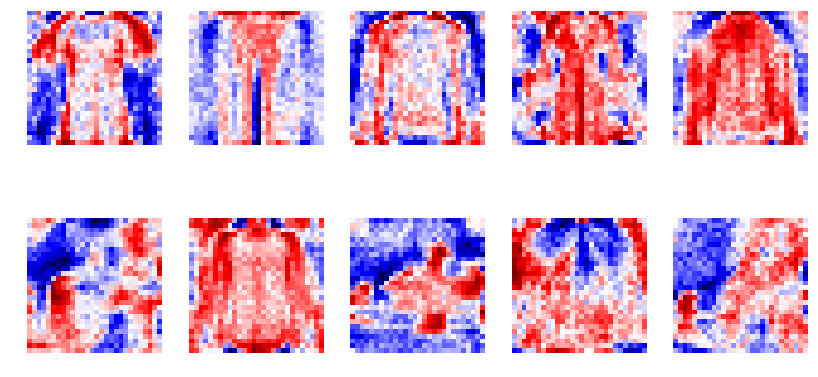

In [7]:
weights, bias = model.layers[0].get_weights() # list of numpy arrays

for i in range(10):
    img1 = weights[:,i]
    plt.subplot(2, 5, i+1)
    plt.imshow(img1.reshape((28, 28)), cmap='seismic')
    plt.axis('off')

<center>
    <h3>Confusion Matrix</h3>
 </center>

- 第6类的错误率较高
- 容易与第0类（T-shirt）、第2类 （Pullover）、第4类（Coat）搞混


30000/30000 [==============================] - 0s 9us/step
(30000,) (30000,)


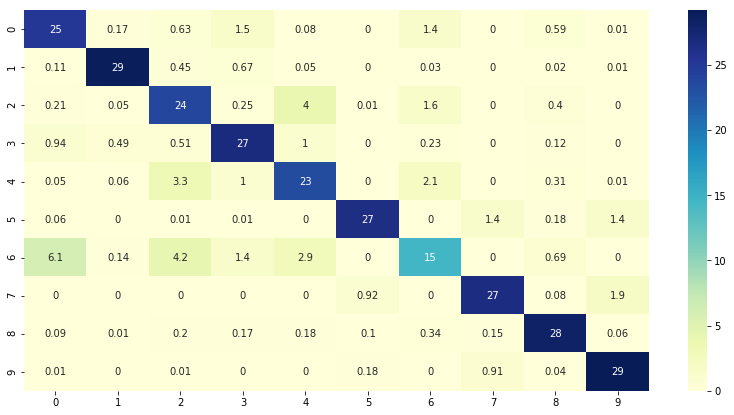

In [8]:
# 预测
pred_X_val = model.predict_classes(X_val, verbose=1)
y_val_true = np.argmax(y_val, axis = 1)
# 真值和预测值
print(y_val_true.shape, pred_X_val.shape)
# 混淆矩阵
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val_true, pred_X_val)
# 混淆矩阵可视化
df_cm = pd.DataFrame(cm/100, index = range(10),
                  columns = range(10))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu")

#### 讲真他们长得确实很像

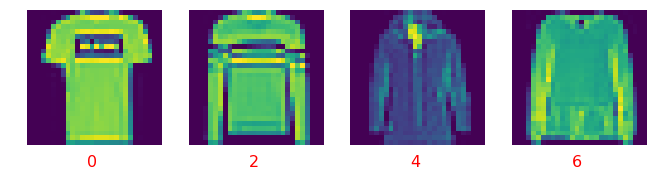

In [9]:
# 0，2，4，6类的第一个图
for i in [0,2,4,6]:
    ind = np.where(y_train0==i)[0][0]
    img1 = X_train0[ind,:]
    plt.subplot(2, 5, i/2+1)
    plt.imshow(img1.reshape((28, 28)))
    plt.axis('off')
    plt.text(12, 32, i,
         fontdict={'size': 16, 'color': 'r'})

<center>
    <h2>3. 卷积神经网络</h2>
 </center>

<center>
    <h3>卷积神经网络概述</h3>
 </center>

#### 普通神经网络示例：3层

<img src="../pictures/network.jpg" alt="network" width="400"/>

#### 卷积神经网络

- 由Layers组成
- 每一层将一个3维的图像输入转化成一个有分类得分的输出
- 通过某些differentiable function转化


- 三维神经元的卷积神经网络，红色部分是输入图片，三个维度储存了图片的RGB信息：

<img src="../pictures/cnn_intro.jpg" alt="cnn_intro1" width="400"/>

#### 三个主要的Layers 

- Convolutional Layer
- Pooling Layer
- Fully-Connected Layer

- a simple ConvNet for CIFAR-10 classification could have the architecture：**INPUT - CONV - RELU - POOL - FC**


- 第一层卷积示例：

<img src="../pictures/conv1.jpg" alt="cnn_intro2" width="300"/>

- Pooling:  \[224x224x64\] to \[112x112x64\]
- pooled with filter size 2, stride 2

<img src="../pictures/pooling.jpg" alt="cnn_intro3" width="400"/>

- Most common: Maxpooling

<img src="../pictures/maxpooling.jpg" alt="cnn_intro4" width="400"/>

#### 多层卷积神经网络示例（A Mini VGGNet）

<img src="../pictures/multi-cnn.jpg" alt="cnn_intro4" width="800"/>

<center>
    <h3>卷积神经网络搭建</h3>
 </center>
 
 #### 一层神经网络搭建

In [11]:
### 测试一层神经网络 ###
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(input_shape=(784,)))

# The input is a flattened array with 784 elements,
# but the convolutional layers expect images with shape (28, 28, 1)
model.add(Reshape((28, 28, 1)))

# First convolutional layer with ReLU-activation (rectified linear unit) and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 name='layer_conv1')) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(10, activation='softmax'))

# 一层神经网络训练
model.summary()
model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr = 0.001), metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 100, epochs = 10,
         validation_data = (X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                31370     
Total params: 31,786
Trainable params: 31,786
Non-trainable params: 0
_________________________________________________________________
Train 

#### 一层神经网络效果如何？

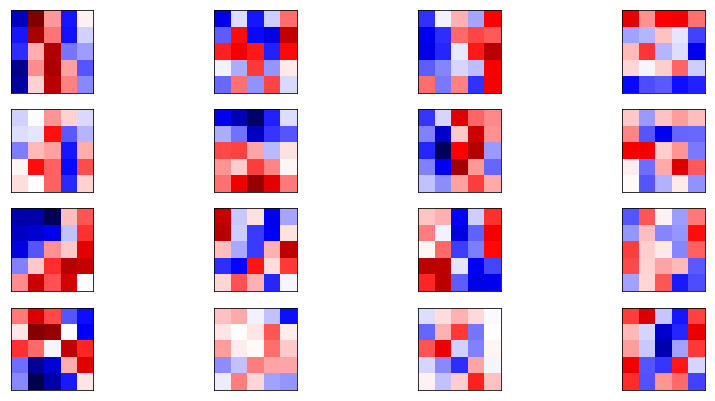

In [12]:
layer_conv1 = model.layers[1]
weights_conv1 = layer_conv1.get_weights()[0]
weights_conv1.shape
plot_conv_weights(weights_conv1)

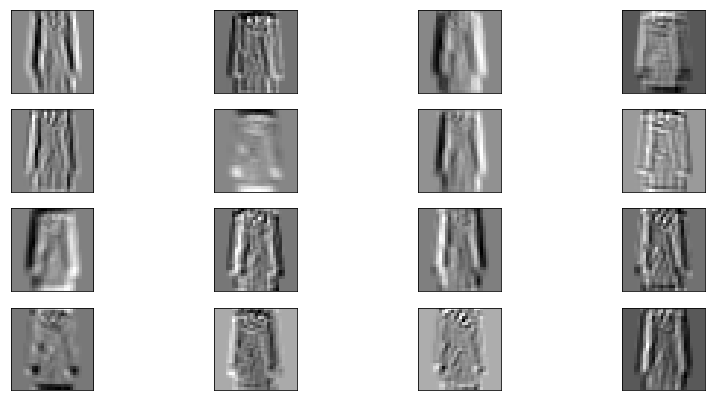

In [13]:
ind = np.where(y_train0==2)[0][0]  # 第二个分类
layer_input = model.layers[0]
output_conv1 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv1.output])
layer_output1 = output_conv1([[X_train[ind]]])[0]
layer_output1.shape
plot_conv_output(values=layer_output1)  # 一层神经网络训练出来的coat类16个图像

#### 两层神经网络搭建

In [ ]:
### 测试两层神经网络 ###
input_layer = Input([784], name  = "I")
x = input_layer
x = Reshape((28,28,1))(x)
# conv
x = Conv2D(kernel_size=1, strides=1, filters=100, padding='same',
                  activation='relu', name='C0')(x)
x = Conv2D(kernel_size=4, strides=1, filters=100, padding='same',
                 name='C1')(x)
# max pooling
x = MaxPooling2D(pool_size=2, name = "P")(x)
x = Flatten(name='F')(x)
x = Dense(10,name='D')(x)
x = Activation('softmax',name='A')(x)
output_layer = x
model = Model(input_layer,output_layer)
model.summary()

# 训练两层神经网络
model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr = 0.001), metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 100, epochs = 10,
         validation_data = (X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
I (InputLayer)               (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
C0 (Conv2D)                  (None, 28, 28, 100)       200       
_________________________________________________________________
C1 (Conv2D)                  (None, 28, 28, 100)       160100    
_________________________________________________________________
P (MaxPooling2D)             (None, 14, 14, 100)       0         
_________________________________________________________________
F (Flatten)                  (None, 19600)             0         
_________________________________________________________________
D (Dense)                    (None, 10)                196010    
__________

#### 两层神经网络效果如何？

(1, 28, 28, 100)


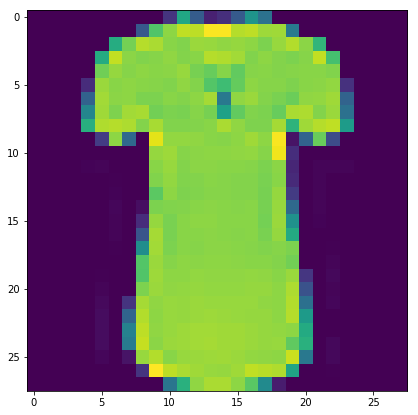

<Figure size 1008x504 with 0 Axes>

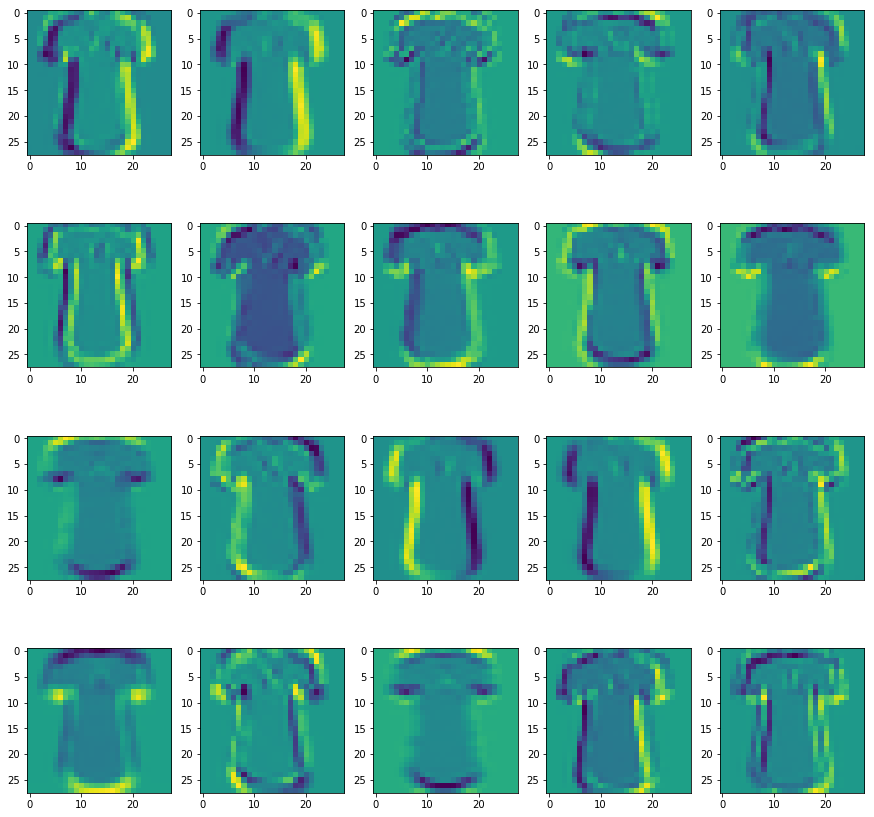

In [16]:
# 提取出拟合正确的数据子集
y_hat = np.argmax(model.predict(X_train),axis=1)
y_true = np.argmax(y_train,axis=1)
flag = (y_hat==y_true)  # 拟合正确的子集index
XX = X_train[flag,:];YY = y_train[flag,:]

nn = 0  # 画出第一个看看
plt.imshow(XX[nn,:].reshape((28,28)))

MyInput=model.get_layer('I').output
MyOutput=model.get_layer('C1').output
model=Model(MyInput,MyOutput)
Z=model.predict(XX[nn:(nn+1),:])
print(Z.shape)

plt.figure()
fig,ax=plt.subplots(4,5)
fig.set_figwidth(15)
fig.set_figheight(15)
ax=ax.flatten()
for i in range(20):
    ax[i].imshow(Z[0,:,:,i])

<center>
    <h3>CNN进阶 1：AlexNet</h3>
 </center>

#### 相比传统的CNN（比如LeNet），改变的地方：

- **Data Augmentation**：水平翻转、随机裁剪、平移变换、颜色、光照变换
- **ReLU**(Rectified Linear Units): f(x)=max(0,x)，training error收敛更快
- **Local Response Normalization**，利用临近的数据做归一化
- **Dropout**：防止神经网络的过拟合
- **Overlapping Pooling**，Pooling的步长比Pooling Kernel的对应边要小

<img src="../pictures/alexnet.jpg" alt="alexnet" width="800"/>

#### AlexNet 搭建

In [17]:
### 实现AlexNet
model = Sequential()
# input layer 输入28*28的图片
model.add(InputLayer(input_shape=(784,)))
# 转换成28*28*1的图片格式
model.add(Reshape((28, 28, 1)))

# 第一个conv+pooling
model.add(Conv2D(kernel_size=5, strides=1, filters=96, padding='same',
                 activation = "relu", name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# 第二个conv+pooling
model.add(Conv2D(kernel_size=5, strides=1, filters=256, padding='same',
                 activation = "relu", name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# 连续三个卷积层
model.add(Conv2D(kernel_size=5, strides=1, filters=384, padding='same',
                 activation = "relu", name='layer_conv3'))
model.add(Conv2D(kernel_size=5, strides=1, filters=384, padding='same',
                 activation = "relu", name='layer_conv4'))
model.add(Conv2D(kernel_size=5, strides=1, filters=256, padding='same',
                 activation = "relu", name='layer_conv5'))
# 利用pooling来减小输出的高和宽
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(4096, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 96)        2496      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 96)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 256)       614656    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
layer_conv3 (Conv2D)         (None, 7, 7, 384)         2457984   
_________________________________________________________________
layer_conv4 (Conv2D)         (None, 7, 7, 384)         3686784   
__________

In [18]:
# 训练AlexNet
model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr = 0.001), metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 100, epochs = 20,
         validation_data = (X_val, y_val))

Train on 30000 samples, validate on 30000 samples
Epoch 1/20
30000/30000 [==============================] - 19s 633us/step - loss: 0.8400 - acc: 0.6775 - val_loss: 0.4300 - val_acc: 0.8388
Epoch 2/20
30000/30000 [==============================] - 18s 605us/step - loss: 0.3995 - acc: 0.8541 - val_loss: 0.3974 - val_acc: 0.8569
Epoch 3/20
30000/30000 [==============================] - 18s 606us/step - loss: 0.3220 - acc: 0.8814 - val_loss: 0.3061 - val_acc: 0.8889
Epoch 4/20
30000/30000 [==============================] - 18s 606us/step - loss: 0.2857 - acc: 0.8965 - val_loss: 0.2888 - val_acc: 0.8949
Epoch 5/20
30000/30000 [==============================] - 18s 607us/step - loss: 0.2520 - acc: 0.9069 - val_loss: 0.2953 - val_acc: 0.8878
Epoch 6/20
30000/30000 [==============================] - 18s 608us/step - loss: 0.2367 - acc: 0.9143 - val_loss: 0.2710 - val_acc: 0.8989
Epoch 7/20
30000/30000 [==============================] - 18s 608us/step - loss: 0.2083 - acc: 0.9245 - val_loss: 0.

<center>
    <h3>CNN进阶 2：VGGNet</h3>
 </center>

#### VGG (Visual Geometry Group)

- 使用很小的卷积，增加网络的深度能够在一定程度上影响网络最终的性能
- **一个字：深，两个字：更深**
- 所有隐藏层都使用ReLu，不使用局部响应标准化(LRN)
- 优化方法(optimizer)：含有动量的 SGD+momentum(0.9) 

<img src="../pictures/vggnet.png" alt="vggnet" width="600"/>

#### VGGNet 搭建

In [19]:
# VGG Net
## num_convs次卷积 + 1次pooling 
def vgg_block(num_convs, num_channels):  # 第一个参数是卷积数量
    blk = Sequential()
    for _ in range(num_convs):
        blk.add(Conv2D(kernel_size=3, strides=1, filters=num_channels, padding='same',
                       activation = "relu"))
    blk.add(MaxPooling2D(pool_size=2, strides=2))
    return blk
    
def vgg(conv_arch):
    model = Sequential()
    model.add(InputLayer(input_shape=(784,)))
    model.add(Reshape((28, 28, 1)))
    for (num_convs, num_channels) in conv_arch:
        ## 卷积和pooling做了循环，参考conv_arch中的第一个参数
        model.add(vgg_block(num_convs, num_channels))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu')) 
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu')) 
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512))
small_conv_arch = [(pair[0], pair[1]//4) for pair in conv_arch]
model = vgg(small_conv_arch)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 14, 14, 16)        160       
_________________________________________________________________
sequential_6 (Sequential)    (None, 7, 7, 32)          4640      
_________________________________________________________________
sequential_7 (Sequential)    (None, 3, 3, 64)          55424     
_________________________________________________________________
sequential_8 (Sequential)    (None, 1, 1, 128)         221440    
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              528384    
__________

In [20]:
# 训练VGG网络
model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr = 0.001), metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 100, epochs = 20,
         validation_data = (X_val, y_val))

Train on 30000 samples, validate on 30000 samples
Epoch 1/20
30000/30000 [==============================] - 6s 190us/step - loss: 0.7070 - acc: 0.7272 - val_loss: 0.4132 - val_acc: 0.8455
Epoch 2/20
30000/30000 [==============================] - 5s 164us/step - loss: 0.3885 - acc: 0.8566 - val_loss: 0.3414 - val_acc: 0.8768
Epoch 3/20
30000/30000 [==============================] - 5s 168us/step - loss: 0.3232 - acc: 0.8829 - val_loss: 0.3260 - val_acc: 0.8829
Epoch 4/20
30000/30000 [==============================] - 5s 173us/step - loss: 0.2884 - acc: 0.8951 - val_loss: 0.2864 - val_acc: 0.8957
Epoch 5/20
30000/30000 [==============================] - 5s 173us/step - loss: 0.2586 - acc: 0.9062 - val_loss: 0.2792 - val_acc: 0.8980
Epoch 6/20
30000/30000 [==============================] - 5s 172us/step - loss: 0.2412 - acc: 0.9122 - val_loss: 0.3147 - val_acc: 0.8859
Epoch 7/20
30000/30000 [==============================] - 5s 178us/step - loss: 0.2203 - acc: 0.9190 - val_loss: 0.3150 - 

<center>
    <h3>CNN进阶 3：ResNet</h3>
 </center>


<img src="../pictures/revolution_of_depth.jpg" alt="revolution" width="700"/>

#### ResNet (Deep residual network)

- Degradation problem：网络深度增加时，网络准确度出现饱和，甚至出现下降。
- **没有最深，只有更深（152层）**


- 创新：**残差网络**
- 实际上残差不会为0，这也会使得堆积层在输入特征基础上学习到新的特征，从而拥有更好的性能
- 借鉴了Highway Network思想：旁边专门开个通道使得输入可以直达输出


- 残差学习单元：

<img src="../pictures/resnet1.jpg" alt="resnet1" width="400"/>

- 参考了VGG19网络，在其基础上进行了修改，并通过短路机制加入了残差单元


- 不同深度的ResNet：

<img src="../pictures/resnet2.jpg" alt="resnet2" width="700"/>

- **Pre-activation**：BN 和 ReLU 都提前

<img src="../pictures/resnet3.png" alt="resnet3" width="800"/>

#### ResNet 搭建

In [21]:
# ResNet
def resnet_subblock(input_tensor, num_channels, use_1x1conv = False, strides = 1):
    
    blk = Sequential()
    # 一次padding
    blk.add(ZeroPadding2D(padding=(1, 1)))
    # 一次conv
    blk.add(Conv2D(kernel_size=3, strides=strides, filters=num_channels))
    blk.add(BatchNormalization())
    blk.add(Activation("relu"))
    # 一次padding
    blk.add(ZeroPadding2D(padding=(1, 1)))
    # 一次conv
    blk.add(Conv2D(kernel_size=3, filters=num_channels))
    blk.add(BatchNormalization())
    x = blk(input_tensor)
    
    '''
    x = Conv2D(kernel_size=3, strides=strides, filters=num_channels, 
               padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(kernel_size=3, filters=num_channels, 
               padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    '''
    
    if use_1x1conv:
        # 条件里再一次conv
        input_tensor = Conv2D(kernel_size=1, strides=strides, 
                              filters=num_channels)(input_tensor)
    x = add([x, input_tensor])
    return x
    
def resnet_block(x, num_channels, num_residuals, first_block = False):
    model = Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            # num_residuals第一个取值&first_block=F时，padding+conv+padding+conv+conv
            x = resnet_subblock(x, num_channels = num_channels, use_1x1conv=True, strides=2)
        else:
            # 不满足条件：padding+conv+padding+conv
            x = resnet_subblock(x, num_channels = num_channels)
    return x

img_input = Input(shape = (784, ))
x = Reshape((28, 28, 1))(img_input)
# 一次conv
x = Conv2D(kernel_size=3, strides=1, filters=16, 
           padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

n = 2
# (P+C+P+C)*2
x = resnet_block(x, num_channels = 16, num_residuals = n, first_block = True)
# (P+C+P+C+C)+(P+C+P+C)
x = resnet_block(x, num_channels = 32, num_residuals = n)
# (P+C+P+C+C)+(P+C+P+C)
x = resnet_block(x, num_channels = 64, num_residuals = n)

# 一次global的pooling
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation="softmax")(x)

model = Model(img_input, x, name = 'resnet50')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 28, 28, 1)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 16)   160         reshape_6[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 16)   64          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation

In [27]:
# 训练resnet网络
model.compile(loss = "categorical_crossentropy", optimizer = SGD(lr = 0.01, decay=1e-4), metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 100, epochs = 20,
          validation_data = (X_val, y_val))

Train on 30000 samples, validate on 30000 samples
Epoch 1/20
30000/30000 [==============================] - 7s 218us/step - loss: 0.0882 - acc: 0.9694 - val_loss: 0.2589 - val_acc: 0.9134
Epoch 2/20
30000/30000 [==============================] - 6s 188us/step - loss: 0.0682 - acc: 0.9791 - val_loss: 0.2823 - val_acc: 0.9052
Epoch 3/20
30000/30000 [==============================] - 5s 177us/step - loss: 0.0619 - acc: 0.9815 - val_loss: 0.3641 - val_acc: 0.8776
Epoch 4/20
30000/30000 [==============================] - 6s 186us/step - loss: 0.0546 - acc: 0.9843 - val_loss: 0.3524 - val_acc: 0.8941
Epoch 5/20
30000/30000 [==============================] - 5s 173us/step - loss: 0.0500 - acc: 0.9861 - val_loss: 0.2655 - val_acc: 0.9152
Epoch 6/20
30000/30000 [==============================] - 6s 192us/step - loss: 0.0471 - acc: 0.9872 - val_loss: 0.2820 - val_acc: 0.9107
Epoch 7/20
30000/30000 [==============================] - 6s 195us/step - loss: 0.0432 - acc: 0.9892 - val_loss: 0.3426 - 